In [75]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.covariance import OAS, EmpiricalCovariance, EllipticEnvelope
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.kernel_approximation import Nystroem
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from utils import print_all_results, save_pickle, show_confusion_matrix, show_parallel_plot

plt.style.use("seaborn-v0_8")

random_state = 42

LR_name = "LR"
RF_name = "RF"
KNN_name = "KNR"
SVM_name = "SVR"

# Data Aquisition

In [76]:
df = pd.read_csv("train.csv").drop_duplicates()

train, test = train_test_split(df, stratify=df["Year"], test_size=0.3, random_state=random_state)
val, test = train_test_split(test, stratify=test["Year"], test_size=1 / 3, random_state=random_state)

X_train = train.drop(columns=["Year"])
y_train = train["Year"]

X_val = val.drop(columns=["Year"])
y_val = val["Year"]

X_test = test.drop(columns=["Year"])
y_test = test["Year"]

print("X_train: {}\nX_val: {}\nX_test: {}".format(X_train.shape, X_val.shape, X_test.shape))

X_train: (176486, 90)
X_val: (50424, 90)
X_test: (25213, 90)


## Outlier Removal

In [77]:
if False:
    columns = [col for col in train.columns if col != "Year"]
    outliers = pd.Series(index=train.index, dtype=bool)

    for year in train["Year"].unique():
        subset = train[train["Year"] == year]
        clf = LocalOutlierFactor(n_neighbors=25, contamination=0.001, n_jobs=-1)
        # clf = IsolationForest(
        #     max_samples=1.0,
        #     contamination=0.001,
        #     n_jobs=-1,
        #     random_state=random_state,
        # )
        outliers[subset.index] = clf.fit_predict(subset[columns]) == -1

    print(outliers.sum())
    train = train[~outliers]

    X_train = train.drop(columns=["Year"])
    y_train = train["Year"]

## Under/Over sampling

In [78]:
if False:
    with pd.option_context("display.max_columns", None):
        display(pd.DataFrame(y_train.value_counts().sort_index()).transpose().style.set_caption("TRAIN: labels count"))

    X_resampled, y_resampled = X_train, y_train

    # Undersampling strategy: undersample the most frequent classes to a limited number of samples
    if False:
        print("Undersampling...")
        max_samples = 100000  # total samples wanted after undersampling
        # number of samples per class to respect the total_samples limit
        samples_per_class = max_samples // len(np.unique(y_train))
        # count number of samples per label (for each row: index is the label, value is the count)
        counts = np.bincount(y_train)
        sampling_strategy_under = {
            class_label: min(samples_per_class, counts[class_label]) for class_label in np.unique(y_train)
        }

        under = RandomUnderSampler(sampling_strategy=sampling_strategy_under, random_state=random_state)
        X_resampled, y_resampled = under.fit_resample(X_resampled, y_resampled)

        # Add to test set the removed samples
        mask = np.isin(X_train, X_resampled).all(axis=1)
        X_removed = X_train[~mask]
        y_removed = y_train[~mask]
        X_test = pd.DataFrame(np.concatenate((X_test, X_removed)))
        y_test = np.concatenate((y_test, y_removed))

        X_train = pd.DataFrame(X_resampled)
        y_train = y_resampled

    # Oversampling strategy: oversample all the classes to the maximum count
    if True:
        print("Oversampling...")
        # count number of samples per label (for each row: index is the label, value is the count)
        counts = np.bincount(y_train)
        # find the maximum count across all classes
        max_count = np.max(counts)
        sampling_strategy_over = {
            class_label: max_count for class_label in np.unique(y_train) if counts[class_label] < max_count
        }

        over = SMOTE(sampling_strategy=sampling_strategy_over, k_neighbors=20, random_state=random_state)
        X_resampled, y_resampled = over.fit_resample(X_resampled, y_resampled)

        X_train = pd.DataFrame(X_resampled)
        y_train = y_resampled

    with pd.option_context("display.max_columns", None):
        display(
            pd.DataFrame(y_train.value_counts().sort_index())
            .transpose()
            .style.set_caption("RESAMPLED Train: labels count")
        )
    print("X_train: {}\nX_val: {}\nX_test: {}".format(X_train.shape, X_val.shape, X_test.shape))

---
# Preprocessing

In [79]:
# step_name, [(transformer_name, transformer_constructor()), ...], step_param_grid
transformers_list = [
    ("raw", [("raw", "passthrough")], {}),  # does nothing to the data
    ("std-scaled", [("std-scaler", preprocessing.StandardScaler())], {}),
    ("min-maxed", [("min-max", preprocessing.MinMaxScaler())], {}),
    (
        "std-scaler + pca 0.95",
        [
            ("std-scaler", preprocessing.StandardScaler()),
            ("pca", PCA(random_state=random_state)),
        ],
        {
            "pca__svd_solver": ["full"],
            "pca__n_components": [0.95],
            "pca__whiten": [True, False],
        },
    ),
    (
        "min-max + pca 0.95",
        [
            ("min-max", preprocessing.MinMaxScaler()),
            ("pca", PCA(random_state=random_state)),
        ],
        {
            "pca__svd_solver": ["full"],
            "pca__n_components": [0.95],
            "pca__whiten": [True, False],
        },
    ),
    (
        "min-max + lmax + pca 0.95",
        [
            ("min-max", preprocessing.MinMaxScaler()),
            ("lmax", preprocessing.Normalizer(norm="max")),
            ("pca", PCA(random_state=random_state)),
        ],
        {
            "pca__svd_solver": ["full"],
            "pca__n_components": [0.95],
            "pca__whiten": [True, False],
        },
    ),
    (
        "min-max + lda",
        [("min-max", preprocessing.MinMaxScaler()), ("lda", LinearDiscriminantAnalysis())],
        {
            "lda__solver": ["eigen"],
            "lda__shrinkage": [None],
            "lda__covariance_estimator": [
                EllipticEnvelope(random_state=random_state, contamination=0.001),
                EmpiricalCovariance(),
                OAS(),
                None,
            ],
        },
    ),
    (
        "min-max + lmax + lda",
        [
            ("min-max", preprocessing.MinMaxScaler()),
            ("lmax", preprocessing.Normalizer(norm="max")),
            ("lda", LinearDiscriminantAnalysis()),
        ],
        {
            "lda__solver": ["eigen"],
            "lda__shrinkage": [None],
            "lda__covariance_estimator": [
                EllipticEnvelope(random_state=random_state, contamination=0.001),
                EmpiricalCovariance(),
                OAS(),
                None,
            ],
        },
    ),
    (
        "min-max + nystroem",
        [
            ("min-max", preprocessing.MinMaxScaler()),
            ("nys", Nystroem(random_state=random_state, n_jobs=-1)),
        ],
        {
            "nys__gamma": [0.010],  # 0, 0.00001, 0.0001, 0.001, 0.050, 1
            "nys__n_components": [1000],  # 10, 100, 500, 700, 900,
        },
    ),
    (
        "min-max + lda + nystroem",
        [
            ("min-max", preprocessing.MinMaxScaler()),
            ("lda", LinearDiscriminantAnalysis()),
            ("nys", Nystroem(random_state=random_state, n_jobs=-1)),
        ],
        {
            "lda__solver": ["eigen"],
            "lda__covariance_estimator": [OAS()],
            "nys__gamma": [0.010],  # 0, 0.00001, 0.0001, 0.001, 0.050, 1
            "nys__n_components": [1000],  # 10, 100, 500, 700, 900,
        },
    ),
    (
        "std-scaler + lda + nystroem",
        [
            ("std-scaler", preprocessing.StandardScaler()),
            ("lda", LinearDiscriminantAnalysis()),
            ("nys", Nystroem(random_state=random_state, n_jobs=-1)),
        ],
        {
            "lda__solver": ["eigen"],
            "lda__covariance_estimator": [OAS()],
            "nys__gamma": [0.010],  # 0, 0.00001, 0.0001, 0.001, 0.050, 1
            "nys__n_components": [1000],  # 10, 100, 500, 700, 900,
        },
    ),
    (
        "min-max + l1 + lda + nystroem",
        [
            ("min-max", preprocessing.MinMaxScaler()),
            ("l1", preprocessing.Normalizer(norm="l1")),
            ("lda", LinearDiscriminantAnalysis()),
            ("nys", Nystroem(random_state=random_state, n_jobs=-1)),
        ],
        {
            "lda__solver": ["eigen"],
            "lda__covariance_estimator": [OAS()],
            "nys__gamma": [0.010],  # 0, 0.00001, 0.0001, 0.001, 0.050, 1
            "nys__n_components": [1000],  # 10, 100, 500, 700, 900,
        },
    ),
]

---
---
# Modeling

- For every preprocess method defined above, execute a GridSearch over the preprocess parameters plus the model parameters, looking for the best model with the best preprocess method (looking at the R^2 score)
- "PredefinedSplit" is chosen to not execute cross-validation, to correctly compare the results with the models of the other tasks
- The use of the Pipeline ensures that the preprocessing methods are fitted only on the training data, and then used to transform all the sets

In [80]:
X_train_val = np.vstack((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))
test_fold = np.zeros(X_train_val.shape[0])
test_fold[: X_train.shape[0]] = -1  # exclude the train set, setting the train indexes to -1
ps = PredefinedSplit(test_fold)


def gridSearch(name_estimator, estimator, param_estimator, save_csv, transformers_list=transformers_list):
    best_r2_score = float("-inf")
    best_MSE_score = float("inf")
    best_preprocessor = []
    best_estimator = None
    best_name_step = None
    best_predictions = []
    best_params = {}

    # Iterate over preprocess techniques
    for name_step, transformers, param_transformers in transformers_list:
        pipe = Pipeline([*transformers, (name_estimator, estimator)])
        gs = GridSearchCV(
            pipe,
            param_grid={**param_estimator, **param_transformers},
            scoring="r2",
            n_jobs=-1,
            cv=ps,
            # verbose=3,
            pre_dispatch=8,
        )

        # Fit
        gs.fit(X_train_val, y_train_val)
        # Predict
        y_pred = gs.predict(X_test.values)
        # Test scores
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        if r2 > best_r2_score:
            best_r2_score = r2
            best_MSE_score = mse
            best_name_step = name_step
            best_preprocessor = gs.best_estimator_[:-1]  # take all but the estimator
            best_estimator = gs.best_estimator_[-1]
            best_params = gs.best_params_
            best_predictions = y_pred

    # Show best result
    print(
        "Best:\n\t{} data\n\tParams: {}\n\tR^2: {}\n\tMSE: {}".format(
            best_name_step, best_params, best_r2_score, best_MSE_score
        )
    )

    # Save in csv the best result
    if save_csv:
        results = pd.DataFrame(best_params or None, index=[0])
        results = results.assign(preprocess=best_name_step, MSE=best_MSE_score, R2=best_r2_score).rename(
            columns={"R2": "R^2"}
        )
        file_name = "outputs/" + "1_" + name_estimator + "_output.csv"
        results = pd.concat([pd.read_csv(file_name) if os.path.isfile(file_name) else pd.DataFrame(), results], axis=0)
        results.to_csv(file_name, index=False)

    return (
        best_preprocessor,
        best_estimator,
        best_predictions,
    )

---
## Linear Regression

In [81]:
best_preprocess_steps = [
    (
        "min-max + lda + nystroem",
        [
            ("min-max", preprocessing.MinMaxScaler()),
            ("lda", LinearDiscriminantAnalysis()),
            ("nys", Nystroem(random_state=random_state, n_jobs=-1)),
        ],
        {
            "lda__solver": ["eigen"],
            "lda__covariance_estimator": [OAS()],
            "nys__gamma": [0.010],  # 0, 0.00001, 0.0001, 0.001, 0.050, 1
            "nys__n_components": [1000],  # 10, 100, 500, 700, 900,
        },
    )
]

param_estimator = {}

best_preprocessor, best_estimator, best_predictions = gridSearch(
    LR_name,
    LinearRegression(n_jobs=-1),
    param_estimator,
    False,
    best_preprocess_steps,
)

Best:
	min-max + lda + nystroem data
	Params: {'lda__covariance_estimator': OAS(), 'lda__solver': 'eigen', 'nys__gamma': 0.01, 'nys__n_components': 1000}
	R^2: 0.3313729550461333
	MSE: 73.59795768847027


In [82]:
save_pickle(1, LR_name, best_preprocessor, best_estimator)

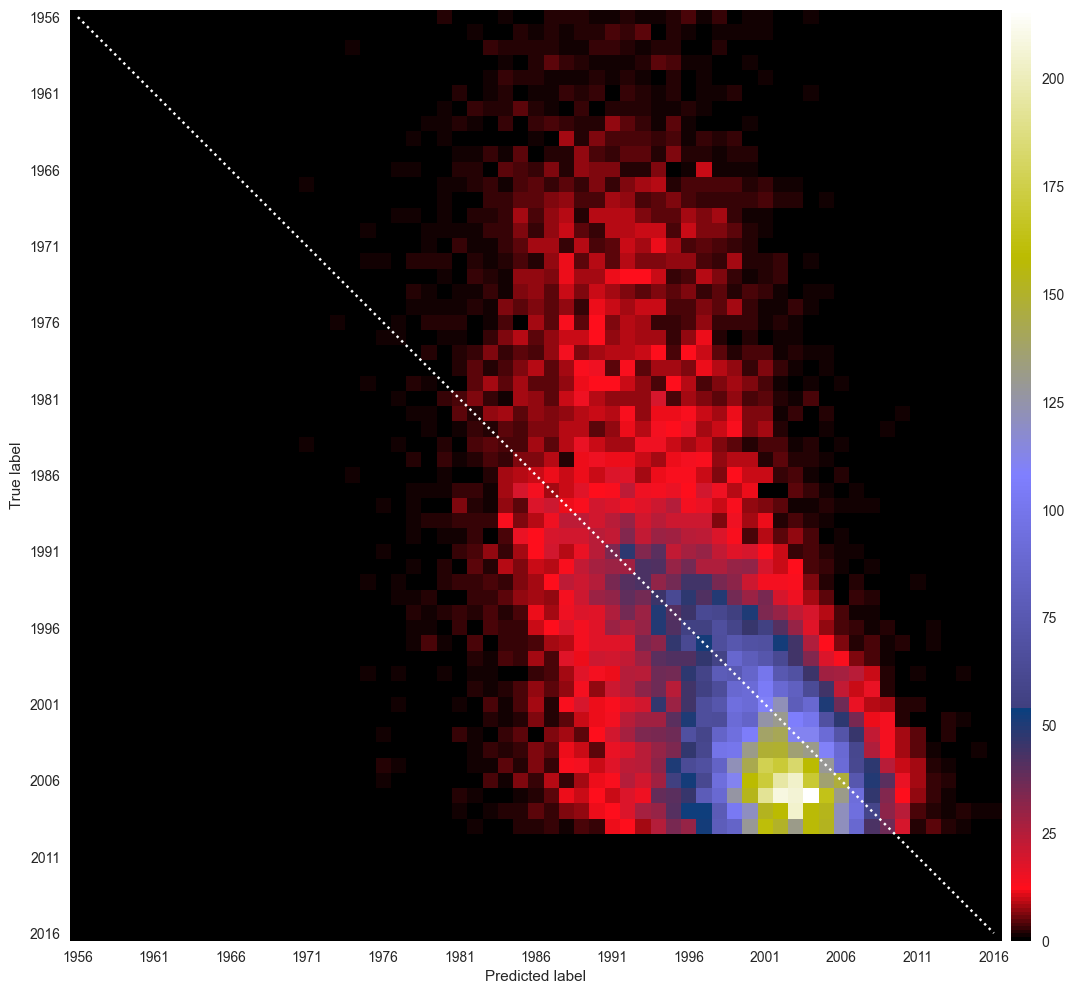

In [83]:
show_confusion_matrix(y_test, best_predictions)

In [84]:
print_all_results(1, LR_name)

,preprocess,pca__n_components,pca__svd_solver,pca__whiten,lda__covariance_estimator,lda__shrinkage,lda__solver,nys__gamma,nys__n_components,MSE,R^2
11,min-max + lda + nystroem,nan,nan,nan,OAS(),nan,eigen,0.0100000,1000.0000000,73.5979577,0.3313730
8,min-max + lmax + lda + nystroem,nan,nan,nan,OAS(),nan,eigen,0.0100000,1000.0000000,73.6178914,0.3311919
10,std-scaler + lda + nystroem,nan,nan,nan,OAS(),nan,eigen,0.0100000,1000.0000000,74.3452920,0.3245835
9,min-max + nystroem,nan,nan,nan,nan,nan,nan,0.0100000,1000.0000000,75.8561394,0.3108577
7,min-max + lmax + lda,nan,nan,nan,EmpiricalCovariance(),nan,eigen,nan,nan,83.3157626,0.2430881
12,min-max + lmax + lda,nan,nan,nan,OAS(),nan,eigen,nan,nan,83.3398224,0.2428695
6,min-max + lda,nan,nan,nan,EmpiricalCovariance(),nan,eigen,nan,nan,83.9731990,0.2371154
2,min-maxed,nan,nan,nan,nan,nan,nan,nan,nan,83.9731990,0.2371154
1,std-scaled,nan,nan,nan,nan,nan,nan,nan,nan,83.9731990,0.2371154
0,raw,nan,nan,nan,nan,nan,nan,nan,nan,83.9731990,0.2371154


In [85]:
show_parallel_plot(1, LR_name)

---
## RandomForestRegressor

In [86]:
best_preprocess_steps = [
    (
        "min-max + lda",
        [
            ("min-max", preprocessing.MinMaxScaler()),
            ("lda", LinearDiscriminantAnalysis()),
        ],
        {
            "lda__solver": ["eigen"],
            "lda__shrinkage": [None],
            "lda__covariance_estimator": [OAS()],
        },
    )
]

param_estimator = {
    "RF__max_samples": [0.66],
    "RF__criterion": ["squared_error"],
    "RF__n_estimators": [200],
    "RF__max_depth": [25],  # 5, 10, 15, 20
    "RF__max_leaf_nodes": [None],  # 50, 100, 200, 300, 400
    "RF__ccp_alpha": [0.01], # 0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0
    "RF__max_features": [0.4],  # "sqrt", "log2", 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9
}

best_preprocessor, best_estimator, best_predictions = gridSearch(
    RF_name,
    RandomForestRegressor(n_jobs=-1, random_state=random_state),
    param_estimator,
    False,
    best_preprocess_steps,
)

Best:
	min-max + lda data
	Params: {'RF__ccp_alpha': 0.01, 'RF__criterion': 'squared_error', 'RF__max_depth': 25, 'RF__max_features': 0.4, 'RF__max_leaf_nodes': None, 'RF__max_samples': 0.66, 'RF__n_estimators': 200, 'lda__covariance_estimator': OAS(), 'lda__shrinkage': None, 'lda__solver': 'eigen'}
	R^2: 0.328599029533612
	MSE: 73.90329270900567


In [87]:
save_pickle(1, RF_name, best_preprocessor, best_estimator)

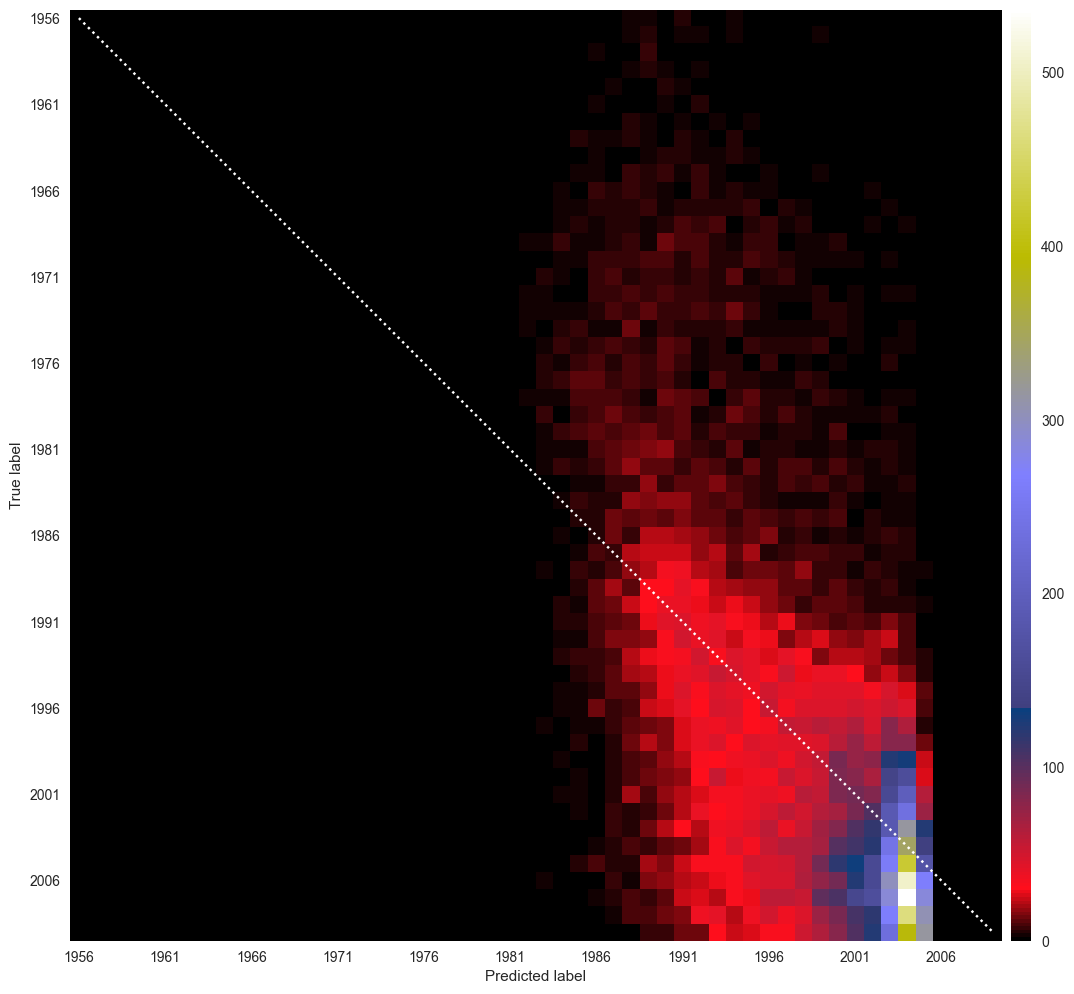

In [88]:
show_confusion_matrix(y_test, best_predictions)

In [89]:
print_all_results(1, RF_name)

,RF__criterion,RF__max_samples,RF__n_estimators,preprocess,pca__n_components,pca__svd_solver,pca__whiten,lda__covariance_estimator,lda__shrinkage,lda__solver,RF__max_depth,RF__max_leaf_nodes,RF__ccp_alpha,RF__max_features,MSE,R^2
35,squared_error,0.6600000,200.0000000,min-max + lda,nan,nan,nan,OAS(),nan,eigen,25.0000000,nan,0.0100000,0.4,73.9032927,0.3285990
36,squared_error,0.6600000,200.0000000,min-max + lda,nan,nan,nan,OAS(),nan,eigen,25.0000000,nan,0.0100000,0.3,73.9197473,0.3284495
37,squared_error,0.6600000,200.0000000,min-max + l2 + lda,nan,nan,nan,OAS(),nan,eigen,25.0000000,nan,0.0100000,0.4,73.9268190,0.3283853
34,squared_error,0.6600000,200.0000000,min-max + lda,nan,nan,nan,OAS(),nan,eigen,25.0000000,nan,0.0100000,0.5,73.9644336,0.3280436
31,squared_error,0.6600000,200.0000000,min-max + lmax + lda,nan,nan,nan,OAS(),nan,eigen,25.0000000,nan,0.0100000,nan,74.2689274,0.3252773
32,squared_error,0.5000000,200.0000000,min-max + lmax + lda,nan,nan,nan,OAS(),nan,eigen,25.0000000,nan,0.0100000,nan,74.2941564,0.3250481
33,squared_error,0.6600000,200.0000000,min-max + lmax + lda,nan,nan,nan,OAS(),nan,eigen,20.0000000,nan,0.0100000,nan,74.3403433,0.3246285
29,squared_error,0.8000000,200.0000000,min-max + lmax + lda,nan,nan,nan,OAS(),nan,eigen,25.0000000,nan,0.0100000,nan,74.3668607,0.3243876
28,squared_error,1.0000000,200.0000000,min-max + lmax + lda,nan,nan,nan,OAS(),nan,eigen,25.0000000,nan,0.0100000,nan,74.3784268,0.3242825
15,squared_error,1.0000000,200.0000000,min-max + lmax + lda,nan,nan,nan,OAS(),nan,eigen,nan,nan,nan,nan,74.7329429,0.3210618


In [90]:
show_parallel_plot(1, RF_name)

---
## KNN

In [91]:
best_preprocess_steps = [
    # (
    #     "min-max + l2 + lda + nystroem",
    #     [
    #         ("min-max", preprocessing.MinMaxScaler()),
    #         ("l2", preprocessing.Normalizer(norm="l2")),
    #         ("lda", LinearDiscriminantAnalysis()),
    #         ("nys", Nystroem(random_state=random_state, n_jobs=-1)),
    #     ],
    #     {
    #         "lda__solver": ["eigen"],
    #         "lda__covariance_estimator": [OAS()],
    #         "nys__gamma": [0.010],  # 0, 0.00001, 0.0001, 0.001, 0.050, 1
    #         "nys__n_components": [1000],  # 10, 100, 500, 700, 900,
    #     },
    # ),
    (
        "min-max + lmax + lda",
        [
            ("min-max", preprocessing.MinMaxScaler()),
            ("lmax", preprocessing.Normalizer(norm="max")),
            ("lda", LinearDiscriminantAnalysis()),
        ],
        {
            "lda__solver": ["eigen"],
            "lda__shrinkage": [None],
            "lda__covariance_estimator": [OAS()],
        },
    ),
]

param_estimator = {
    "KNR__n_neighbors": [21],
    "KNR__weights": ["distance"],  # "uniform"
    "KNR__metric": ["cosine"],  # "euclidean", "cityblock", "nan_euclidean"
    "KNR__leaf_size": [10],
}

best_preprocessor, best_estimator, best_predictions = gridSearch(
    KNN_name,
    KNeighborsRegressor(n_jobs=-1),
    param_estimator,
    False,
    best_preprocess_steps,
)

Best:
	min-max + lmax + lda data
	Params: {'KNR__leaf_size': 10, 'KNR__metric': 'cosine', 'KNR__n_neighbors': 21, 'KNR__weights': 'distance', 'lda__covariance_estimator': OAS(), 'lda__shrinkage': None, 'lda__solver': 'eigen'}
	R^2: 0.3308468026563247
	MSE: 73.65587299658571


In [92]:
save_pickle(1, KNN_name, best_preprocessor, best_estimator)

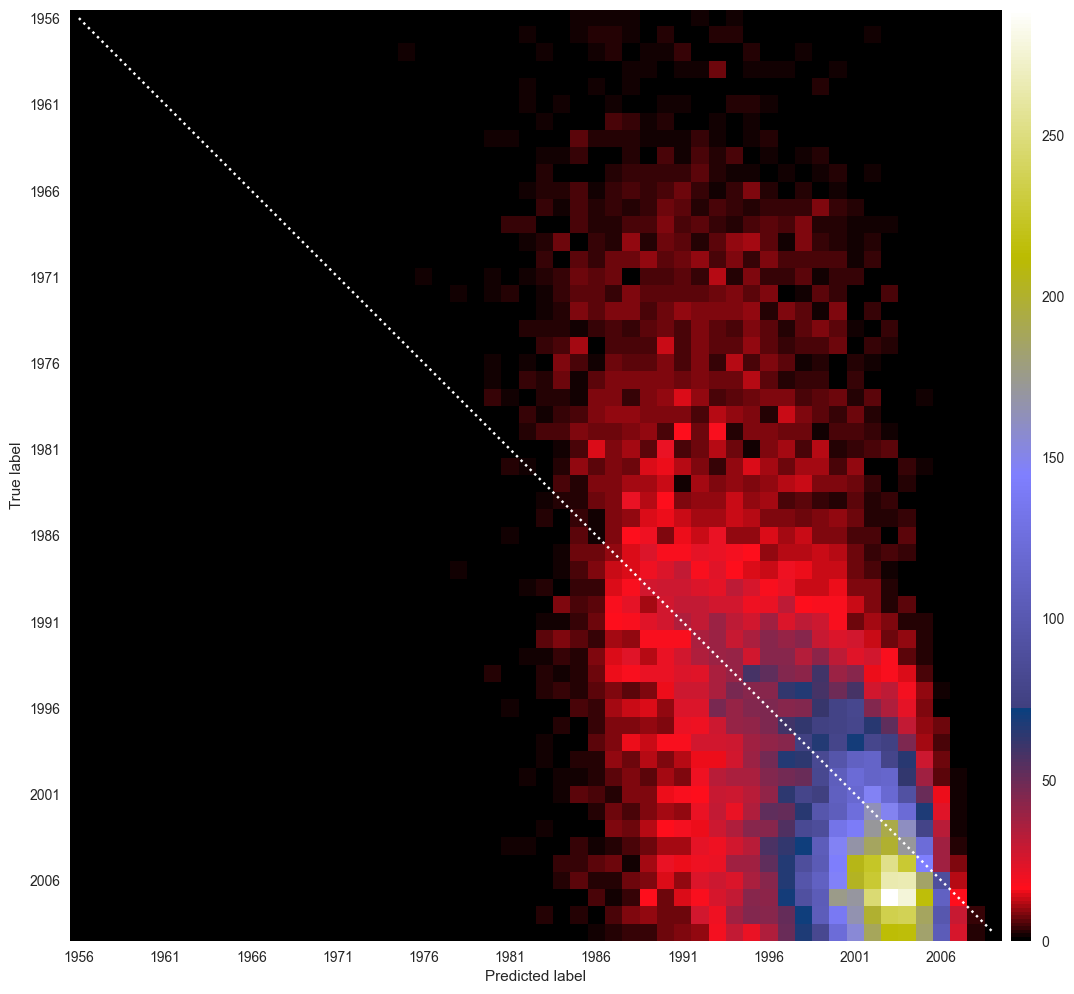

In [93]:
show_confusion_matrix(y_test, best_predictions)

In [94]:
print_all_results(1, KNN_name)

,KNR__metric,KNR__n_neighbors,KNR__weights,lda__covariance_estimator,lda__shrinkage,lda__solver,preprocess,pca__n_components,pca__svd_solver,pca__whiten,KNR__leaf_size,nys__gamma,nys__n_components,MSE,R^2
22,cosine,21,distance,OAS(),nan,eigen,min-max + l2 + lda + nystroem,nan,nan,nan,10.0000000,0.0100000,1000.0000000,73.0442082,0.3364037
19,cosine,21,distance,OAS(),nan,eigen,min-max + lmax + lda,nan,nan,nan,25.0000000,nan,nan,73.6558730,0.3308468
18,cosine,21,distance,OAS(),nan,eigen,min-max + lmax + lda,nan,nan,nan,5.0000000,nan,nan,73.6558730,0.3308468
17,cosine,21,distance,OAS(),nan,eigen,min-max + lmax + lda,nan,nan,nan,20.0000000,nan,nan,73.6558730,0.3308468
15,cosine,21,distance,OAS(),nan,eigen,min-max + lmax + lda,nan,nan,nan,nan,nan,nan,73.6558730,0.3308468
20,cosine,21,distance,OAS(),nan,eigen,min-max + lmax + lda,nan,nan,nan,10.0000000,nan,nan,73.6558730,0.3308468
6,cosine,25,distance,OAS(),nan,eigen,min-max + lmax + lda,nan,nan,nan,nan,nan,nan,73.6801573,0.3306262
16,cosine,23,distance,OAS(),nan,eigen,min-max + lmax + lda,nan,nan,nan,nan,nan,nan,73.6836591,0.3305944
8,cosine,20,distance,OAS(),nan,eigen,min-max + lmax + lda,nan,nan,nan,nan,nan,nan,73.6861822,0.3305714
5,cosine,20,distance,OAS(),nan,eigen,min-max + l1 + lda,nan,nan,nan,nan,nan,nan,73.8715901,0.3288870


In [95]:
show_parallel_plot(1, KNN_name)

---
## SVM

In [96]:
best_preprocess_steps = [
    (
        "min-max + l1 + lda + nystroem",
        [
            ("min-max", preprocessing.MinMaxScaler()),
            ("l1", preprocessing.Normalizer(norm="l1")),
            ("lda", LinearDiscriminantAnalysis()),
            ("nys", Nystroem(random_state=random_state, n_jobs=-1)),
        ],
        {
            "lda__solver": ["eigen"],
            "lda__covariance_estimator": [OAS()],
            "nys__gamma": [0.010],  # 0, 0.00001, 0.0001, 0.001, 0.050, 1
            "nys__n_components": [1000],  # 10, 100, 500, 700, 900,
        },
    )
]

param_estimator = {
    "SVR__epsilon": [0.01],  # 0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0],
    "SVR__tol": [0.0001], # [1e-5, 1e-4, 1e-3, 1e-2],
    "SVR__C": [10],  # 0.1, 1, 100, 500, 5, 20, 8, 9, 15
    "SVR__loss": ["epsilon_insensitive"],  # "squared_epsilon_insensitive"
    "SVR__max_iter": [2000],
}

best_preprocessor, best_estimator, best_predictions = gridSearch(
    SVM_name,
    LinearSVR(dual="auto", random_state=random_state),
    param_estimator,
    False,
    best_preprocess_steps,
)

Best:
	min-max + l1 + lda + nystroem data
	Params: {'SVR__C': 10, 'SVR__epsilon': 0.01, 'SVR__loss': 'epsilon_insensitive', 'SVR__max_iter': 2000, 'SVR__tol': 0.0001, 'lda__covariance_estimator': OAS(), 'lda__solver': 'eigen', 'nys__gamma': 0.01, 'nys__n_components': 1000}
	R^2: 0.2848287228324259
	MSE: 78.72123300160561


In [97]:
save_pickle(1, SVM_name, best_preprocessor, best_estimator)

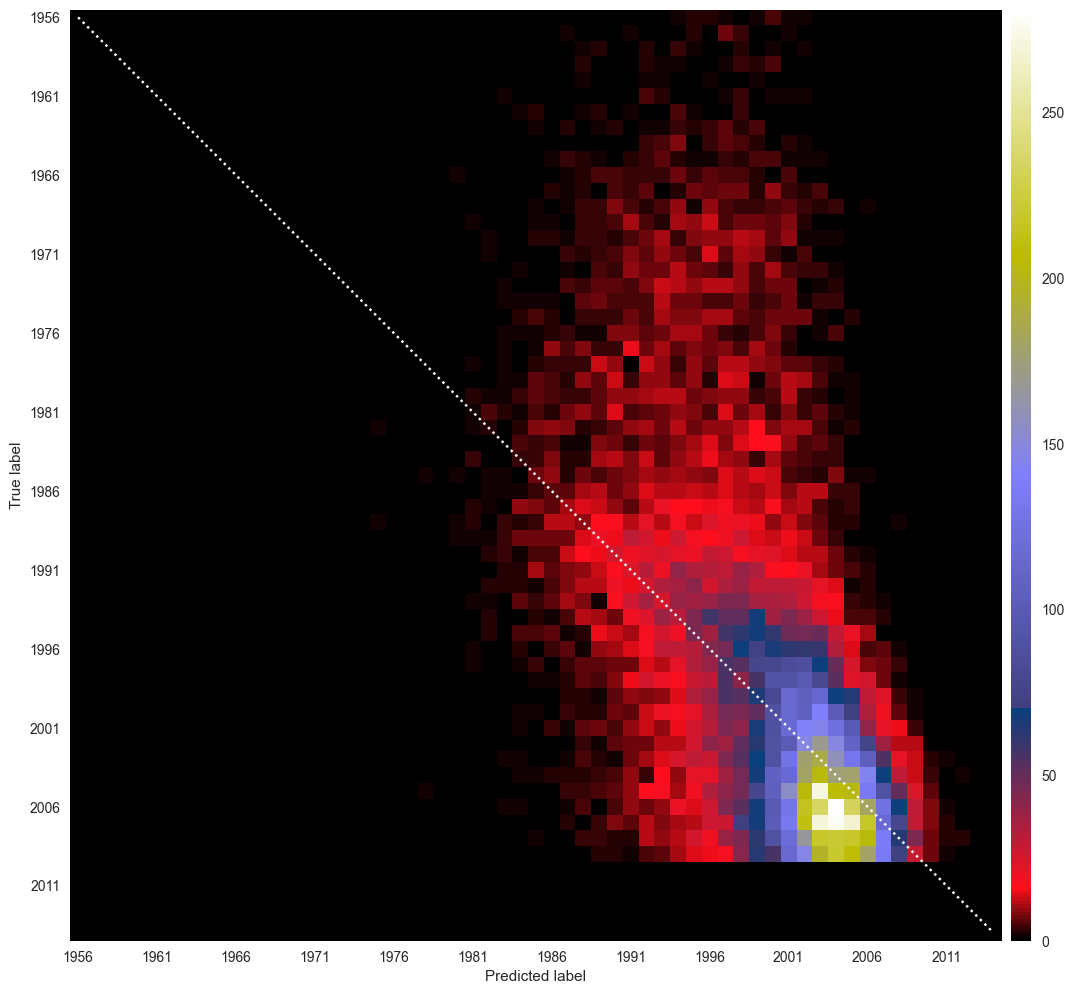

In [98]:
show_confusion_matrix(y_test, best_predictions)

In [99]:
print_all_results(1, SVM_name)

,lda__covariance_estimator,lda__solver,nys__gamma,nys__n_components,preprocess,pca__n_components,pca__svd_solver,pca__whiten,SVR__C,SVR__epsilon,SVR__max_iter,SVR__loss,SVR__tol,MSE,R^2
8,OAS(),eigen,0.0100000,1000.0000000,min-max + l1 + lda + nystroem,nan,nan,nan,10.0000000,0.0100000,2000.0000000,nan,nan,78.7212330,0.2848287
11,OAS(),eigen,0.0100000,1000.0000000,min-max + l1 + lda + nystroem,nan,nan,nan,10.0000000,0.0100000,2000.0000000,epsilon_insensitive,nan,78.7212330,0.2848287
12,OAS(),eigen,0.0100000,1000.0000000,min-max + l1 + lda + nystroem,nan,nan,nan,10.0000000,0.0100000,2000.0000000,epsilon_insensitive,0.0001000,78.7212330,0.2848287
9,OAS(),eigen,0.0100000,1000.0000000,min-max + lda + nystroem,nan,nan,nan,10.0000000,0.0100000,2000.0000000,nan,nan,78.9061170,0.2831491
10,OAS(),eigen,0.0100000,1000.0000000,min-max + l1 + lda + nystroem,nan,nan,nan,10.0000000,nan,2000.0000000,nan,nan,78.9567844,0.2826888
2,OAS(),eigen,0.0100000,1000.0000000,min-max + l1 + lda + nystroem,nan,nan,nan,nan,nan,nan,nan,nan,79.2911086,0.2796515
1,OAS(),eigen,0.0100000,1000.0000000,min-max + lmax + lda + nystroem,nan,nan,nan,nan,nan,nan,nan,nan,79.4122769,0.2785507
7,OAS(),eigen,0.0100000,1000.0000000,min-max + l2 + lda + nystroem,nan,nan,nan,nan,nan,nan,nan,nan,79.5118577,0.2776460
5,OAS(),eigen,0.0100000,1000.0000000,min-max + lda + nystroem,nan,nan,nan,nan,nan,nan,nan,nan,79.5140189,0.2776264
6,OAS(),eigen,0.0100000,1000.0000000,std-scaler + lda + nystroem,nan,nan,nan,nan,nan,nan,nan,nan,79.6422640,0.2764613


In [100]:
show_parallel_plot(1, SVM_name)